Run unsupervised analysis on the macro data (6 factors) to detect regimes.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
#########################################
# 1) Load or Reuse Cleaned Data
#########################################
df = pd.read_csv("../../data/macroeconomic_data_merged.csv", parse_dates=['Month_End'], index_col='Month_End')
print(f"Data loaded from , shape={df.shape}")
df.dropna(inplace=True)
print("Data after final cleaning & feature engineering:", df.shape)

#########################################
# 2) Standardize the data
########################################
features = ['CPI', 'FEDFUNDS', 'Industrial_Production', 'GDP', 'Unemployment_Rate', 'Consumer_Sentiment']
X = df[features].values
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

Data loaded from , shape=(309, 6)
Data after final cleaning & feature engineering: (309, 6)


In [11]:
#########################################
# 3) Define a Function to Compute the Number of Parameters                                                  
#########################################
def compute_num_params(n_states, d, covariance_type):
    # Initial state probabilities: n_states - 1 (since they sum to 1)
    init_params = n_states - 1
    # Transition matrix: n_states*(n_states - 1) (each row sums to 1)
    trans_params = n_states * (n_states - 1)
    # Means: n_states * d
    mean_params = n_states * d
    if covariance_type == 'full':
        # Each state's covariance is a symmetric matrix: d*(d+1)/2 parameters per state
        cov_params = n_states * (d * (d + 1) / 2)
    elif covariance_type == 'diag':
        # Diagonal covariance: d parameters per state
        cov_params = n_states * d
    else:
        raise ValueError("Unsupported covariance type")
    return init_params + trans_params + mean_params + cov_params
#########################################
# 4) Grid Search for Optimal HMM Parameters                                                
#########################################
N=X_scaled.shape[0]
d=X_scaled.shape[1]
best_bic=np.inf
best_config=None
results=[]
cov_types=['full','diag']
for cov in cov_types:
    for n in range(2, 10):  # Testing from 2 to 6 states
        try:
            model = hmm.GaussianHMM(n_components=n, covariance_type=cov, n_iter=1000, random_state=42)
            model.fit(X_scaled)
            logL = model.score(X_scaled)
            p = compute_num_params(n, d, cov)
            # Compute BIC: BIC = -2*logL + p * ln(N)
            bic = -2 * logL + p * np.log(N)
            results.append((n, cov, logL, p, bic))
            print(f"n_states: {n}, covariance_type: {cov}, logL: {logL:.2f}, parameters: {p:.0f}, BIC: {bic:.2f}")
            if bic < best_bic:
                best_bic = bic
                best_config = (n, cov)
        except Exception as e:
            print(f"Error with n_states: {n}, covariance_type: {cov} -- {e}")


n_states: 2, covariance_type: full, logL: -1200.47, parameters: 57, BIC: 2727.75
n_states: 3, covariance_type: full, logL: -585.56, parameters: 89, BIC: 1681.38
n_states: 4, covariance_type: full, logL: -441.99, parameters: 123, BIC: 1589.19
n_states: 5, covariance_type: full, logL: 36.99, parameters: 159, BIC: 837.61


Model is not converging.  Current: 332.0793474378944 is not greater than 332.1038446243948. Delta is -0.02449718650041177


n_states: 6, covariance_type: full, logL: 333.45, parameters: 197, BIC: 462.56
n_states: 7, covariance_type: full, logL: 332.06, parameters: 237, BIC: 694.68
n_states: 8, covariance_type: full, logL: 142.57, parameters: 279, BIC: 1314.47
n_states: 9, covariance_type: full, logL: 498.91, parameters: 323, BIC: 854.04
n_states: 2, covariance_type: diag, logL: -1778.43, parameters: 27, BIC: 3711.66
n_states: 3, covariance_type: diag, logL: -1409.19, parameters: 44, BIC: 3070.65
n_states: 4, covariance_type: diag, logL: -1243.13, parameters: 63, BIC: 2847.45
n_states: 5, covariance_type: diag, logL: -1194.32, parameters: 84, BIC: 2870.25


Model is not converging.  Current: -593.8765192172038 is not greater than -593.6860381497409. Delta is -0.1904810674629971


n_states: 6, covariance_type: diag, logL: -786.43, parameters: 107, BIC: 2186.32
n_states: 7, covariance_type: diag, logL: -594.01, parameters: 132, BIC: 1944.82
n_states: 8, covariance_type: diag, logL: -568.83, parameters: 159, BIC: 2049.27
n_states: 9, covariance_type: diag, logL: -421.39, parameters: 188, BIC: 1920.64


In [12]:
#########################################
# 5）Train the Optimal Model
#########################################
optimal_model=hmm.GaussianHMM(n_components=best_config[0],covariance_type=best_config[1],n_iter=1000,random_state=42)
optimal_model.fit(X_scaled)
hidden_states=optimal_model.predict(X_scaled)
df['Regimes']=hidden_states
state_counts=df['Regimes'].value_counts().sort_index()
print("State sample counts:")
print(state_counts)
print(f"Optimal model log likelihood: {optimal_model.score(X_scaled):.2f}")

State sample counts:
Regimes
0     32
1     18
2     56
3     23
4    121
5     59
Name: count, dtype: int64
Optimal model log likelihood: 333.45


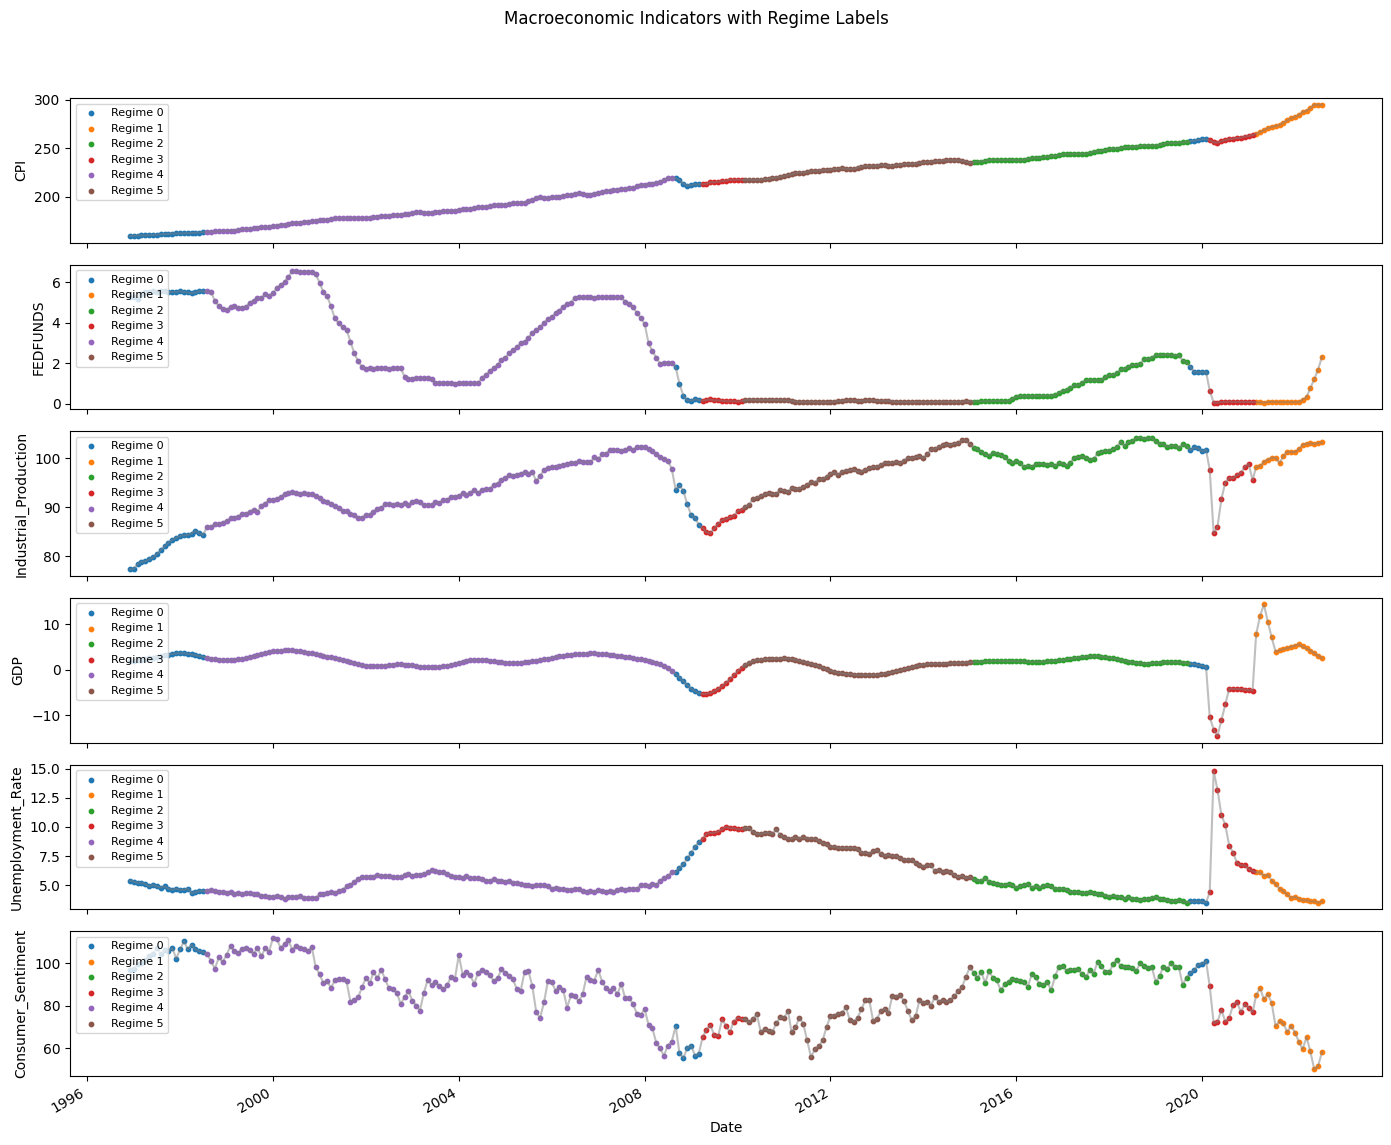

In [13]:
#########################################
# 6) Visualizations
#########################################
# plt.figure(figsize=(14, 6))
# for state in range(best_config[0]):
#     state_mask = (df['Regimes'] == state)
#     plt.plot(df.index[state_mask], df.loc[state_mask, 'GDP'], '.', label=f"Regime {state}")
# plt.xlabel("Date")
# plt.ylabel("GDP")
# plt.title("GDP under Different Regimes")
# plt.legend()
# plt.gcf().autofmt_xdate()
# plt.show()
#Overlay of All Indicators with Regime Labels
fig, axs = plt.subplots(len(features), 1, figsize=(14, 12), sharex=True)
for i, feature in enumerate(features):
    axs[i].plot(df.index, df[feature], color='gray', alpha=0.5)
    for state in range(best_config[0]):
        state_mask = (df['Regimes'] == state)
        axs[i].scatter(df.index[state_mask], df.loc[state_mask, feature], label=f"Regime {state}", s=10)
    axs[i].set_ylabel(feature)
    axs[i].legend(fontsize=8, loc='upper left')
plt.xlabel("Date")
plt.suptitle("Macroeconomic Indicators with Regime Labels")
plt.gcf().autofmt_xdate()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


As we can find the graph results from applying a Hidden Markov Model(HMM) to multiple U.S. macroeconomic indicators.The HMM identifies several hidden "regimes"—distinct states with different statistical properties.

**Regime 0 (Stable Expansion):**  
Reflects the 1990s tech boom. Key indicators like GDP growth, employment, and industrial output show steady increases with low volatility. Financial markets were buoyant, and consumer confidence remained high, supporting robust investment and spending.

**Regime 1 (Early Slowdown):**  
Follows the dot-com burst in the early 2000s. Indicators such as market indices and GDP growth began to decelerate, with rising volatility and cautious business investments, signaling a transition from exuberance to a more measured economic pace.

**Regime 2 (Pre-Crisis Overheating):**  
Characterized by rapid expansion before the 2008 crisis. High credit growth, aggressive housing market activity, and strong GDP gains coexisted with rising asset prices, suggesting potential imbalances and increased risk-taking.

**Regime 3 (Deep Recession):**  
Captures the 2008–2009 financial crisis. Sharp declines in GDP, employment, and industrial production occurred as financial institutions faltered, credit markets tightened, and consumer spending plummeted, reflecting widespread economic distress.

**Regime 4 (Recovery Phase):**  
Represents post-crisis recovery with gradual improvements in GDP, employment, and production. Policy interventions like fiscal stimulus and monetary easing helped restore confidence and stabilize financial markets, leading to a more balanced economic rebound.

**Regime 5 (Pandemic Shock and Rebound):**  
Reflects the COVID-19 impact in 2020. Economic indicators plummeted abruptly due to lockdowns and disrupted supply chains.
In response, the U.S. government enacted massive fiscal measures, notably the CARES Act, which provided direct support to individuals, small businesses, and key industries. Simultaneously, the Federal Reserve implemented aggressive monetary policies by slashing interest rates to near zero and launching quantitative easing programs. 
As a result, by mid-to-late 2020, economic indicators began to rebound rapidly. GDP growth resumed, and unemployment rates gradually declined. 

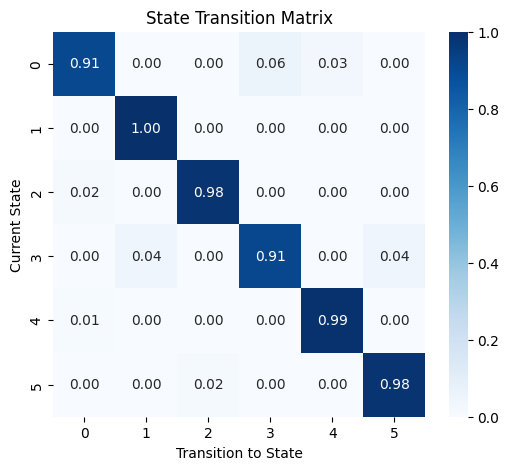

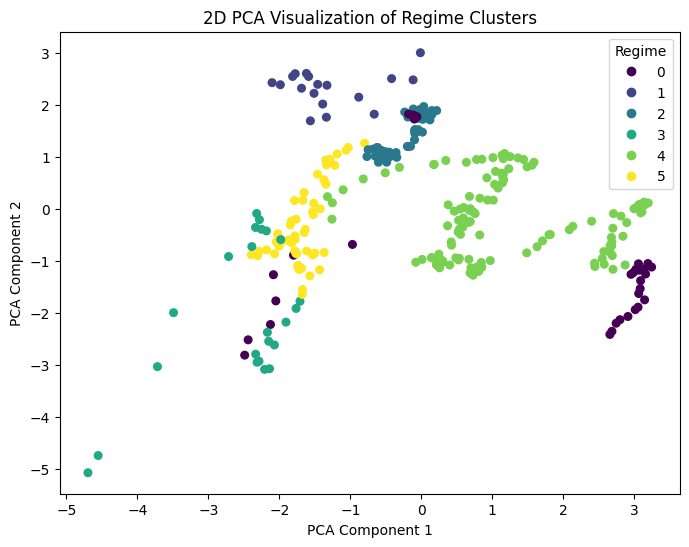

In [14]:
#########################################
# 6）Visualizations
#########################################
from sklearn.decomposition import PCA
plt.figure(figsize=(6, 5))
sns.heatmap(optimal_model.transmat_, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel("Transition to State")
plt.ylabel("Current State")
plt.title("State Transition Matrix")
plt.show()
# PCA Scatter Plot for 2D Visualization of Regimes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hidden_states, cmap='viridis', s=30)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Visualization of Regime Clusters")
plt.legend(*scatter.legend_elements(), title="Regime")
plt.show()

The transition matrix reveals that the HMM is modeling highly persistent states with infrequent shifts

Silhouette Score of the tuned HMM model: 0.280


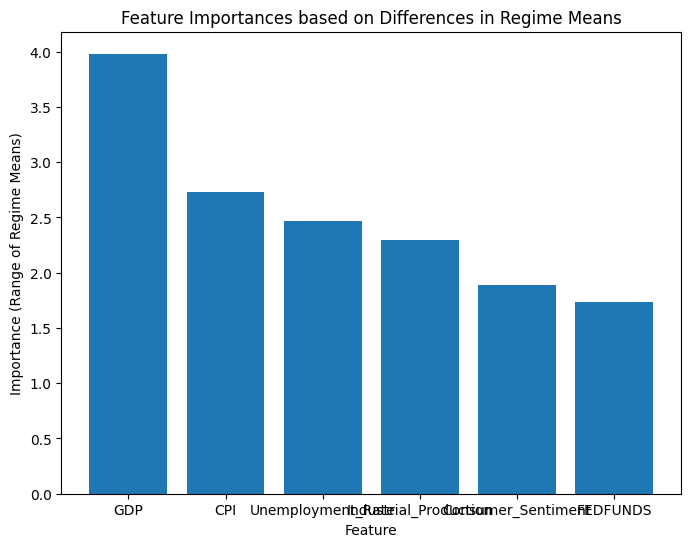


Expected duration for each state based on the transition matrix:
   Regime  Expected Duration
0       0          10.677786
1       1                inf
2       2          55.923060
3       3          11.504233
4       4         120.997413
5       5          59.033987

Empirical average duration for each state:
   Regime  Empirical Average Duration
0       0                   10.666667
1       1                   18.000000
2       2                   56.000000
3       3                   11.500000
4       4                  121.000000
5       5                   59.000000

Comparison of Expected vs. Empirical Duration:
   Regime  Expected Duration  Empirical Average Duration
0       0          10.677786                   10.666667
1       1                inf                   18.000000
2       2          55.923060                   56.000000
3       3          11.504233                   11.500000
4       4         120.997413                  121.000000
5       5          59.033987   

/var/folders/35/m_ptm17s2n9bz53bzfr03csh0000gn/T/ipykernel_49299/388142436.py:35: RuntimeWarning: divide by zero encountered in divide
  expected_durations = 1 / (1 - np.diag(optimal_model.transmat_))


In [ ]:
#########################################
# 7) Evaluate the tuned model 
#########################################
from sklearn.metrics import silhouette_score
##Silhouette Score
# Compute the silhouette score using the standardized data (X_scaled) and the HMM hidden state labels (hidden_states)
sil_score = silhouette_score(X_scaled, hidden_states)
print(f"Silhouette Score of the tuned HMM model: {sil_score:.3f}")

##Plot Feature Importances based on Regime Means Differences
# Retrieve the regime means from the optimal model (each row corresponds to a hidden state's mean vector)
regime_means = optimal_model.means_
feature_importances = np.ptp(regime_means, axis=0)
fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 6))
plt.bar(fi_df['Feature'], fi_df['Importance'])
plt.xlabel("Feature")
plt.ylabel("Importance (Range of Regime Means)")
plt.title("Feature Importances based on Differences in Regime Means")
plt.show()
##Additional Evaluation: Expected Duration vs. Empirical Duration
expected_durations = 1 / (1 - np.diag(optimal_model.transmat_))
expected_duration_df = pd.DataFrame({
    'Regime': range(best_config[0]),
    'Expected Duration': expected_durations
})
print("\nExpected duration for each state based on the transition matrix:")
print(expected_duration_df)

##Calculate Empirical Durations 
# Compute the durations for which each hidden state persists consecutively.
state_durations = []
current_state = hidden_states[0]
duration = 1
for state in hidden_states[1:]:
    if state == current_state:
        duration += 1
    else:
        state_durations.append((current_state, duration))
        current_state = state
        duration = 1
# Append the duration for the last state block.
state_durations.append((current_state, duration))
duration_df = pd.DataFrame(state_durations, columns=['Regime', 'Duration'])
empirical_duration = (
    duration_df.groupby('Regime')['Duration']
    .mean()
    .reset_index()
    .rename(columns={'Duration': 'Empirical Average Duration'})
)
print("\nEmpirical average duration for each state:")
print(empirical_duration)
duration_comparison = pd.merge(expected_duration_df, empirical_duration, on='Regime', how='left')
print("\nComparison of Expected vs. Empirical Duration:")
print(duration_comparison)


According to silhouette score(0.280), the regime classification by the HMM is moderat. There might be some overlap between regimes, which is common in real-world data, especially in complex systems like macroeconomic indicators.
Empirical Average Duration is the observed average number of consecutive time steps that a regime persists in the data. For most regimes, these values (10.67, 56.00, 11.50, 121.00, 59.00) align very well with the model's expectations.
Expected Duration (from Transition Matrix), using the state's self-transition probabilities. For regimes 0, 2, 3, 4, and 5, the expected durations (10.68, 55.92, 11.50, 121.00, 59.03) closely match the empirical averages. 
The close match between the expected and empirical durations for most regimes indicates that the HMM captures the state persistence well. 